# Deep Neural Network for Image Classification: Application

When you finish this, you will have finished the last programming assignment of Week 4, and also the last programming assignment of this course! 

You will use use the functions you'd implemented in the previous assignment to build a deep network, and apply it to cat vs non-cat classification. Hopefully, you will see an improvement in accuracy relative to your previous logistic regression implementation.  

**After this assignment you will be able to:**
- Build and apply a deep neural network to supervised learning. 

Let's get started!

## 1 - Packages

Let's first import all the packages that you will need during this assignment. 
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.
- dnn_app_utils provides the functions implemented in the "Building your Deep Neural Network: Step by Step" assignment to this notebook.
- np.random.seed(1) is used to keep all the random function calls consistent. It will help us grade your work.

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v2 import *  #We created this

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

C:\Users\Priyam\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 2 - Dataset

You will use the same "Cat vs non-Cat" dataset as in "Logistic Regression as a Neural Network" (Assignment 2). The model you had built had 70% test accuracy on classifying cats vs non-cats images. Hopefully, your new model will perform a better!

**Problem Statement**: You are given a dataset ("data.h5") containing:
    - a training set of m_train images labelled as cat (1) or non-cat (0)
    - a test set of m_test images labelled as cat and non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB).

Let's get more familiar with the dataset. Load the data by running the cell below.

In [2]:
train_x_orig, train_y_orig, test_x_orig, test_y_orig, classes = load_data()

In [7]:
train_x_orig.shape

(209, 64, 64, 3)

In [5]:
print(train_x_orig.shape)  #Check the shape
train_y=train_y_orig.T
test_y=test_y_orig.T

(209, 64, 64, 3)


In [8]:
classes

array([b'non-cat', b'cat'], dtype='|S7')

The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images. 

y = 1. It's a cat picture.


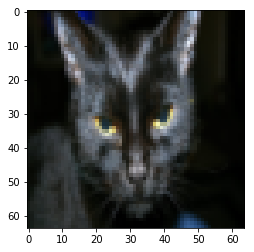

In [11]:
# Example of a picture
index = 25
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[index,0]) + ". It's a " + classes[train_y[index,0]].decode("utf-8") +  " picture.")

In [12]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (209, 1)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (50, 1)


As usual, you reshape and standardize the images before feeding them to the network. The code is given in the cell below.

<img src="images/imvectorkiank.png" style="width:450px;height:300px;">

<caption><center> <u>Figure 1</u>: Image to vector conversion. <br> </center></caption>

In [13]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1)   # The "-1" makes reshape flatten the remaining dimensions
#train_x_flatten = train_x_orig.reshape(-1,train_x_orig.shape[0]) --Checkout this also
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1)

# Standardize data to have feature values between 0 and 1. Similar to feature scaling
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (209, 12288)
test_x's shape: (50, 12288)


$12,288$ equals $64 \times 64 \times 3$ which is the size of one reshaped image vector.

## 3 - Architecture of your model

Now that you are familiar with the dataset, it is time to build a deep neural network to distinguish cat images from non-cat images.

You will build two different models:
- A 2-layer neural network
- An L-layer deep neural network

You will then compare the performance of these models, and also try out different values for $L$. 

Let's look at the two architectures.

### 3.1 - 2-layer neural network

<img src="images/2layerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 2</u>: 2-layer neural network. <br> The model can be summarized as: ***INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT***. </center></caption>

<u>Detailed Architecture of figure 2</u>:
- The input is a (64,64,3) image which is flattened to a vector of size $(12288,1)$. 
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- You then add a bias term and take its relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- You then repeat the same process.
- You multiply the resulting vector by $W^{[2]}$ and add your intercept (bias). 
- Finally, you take the sigmoid of the result. If it is greater than 0.5, you classify it to be a cat.

### 3.2 - L-layer deep neural network

It is hard to represent an L-layer deep neural network with the above representation. However, here is a simplified network representation:

<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 3</u>: L-layer neural network. <br> The model can be summarized as: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

<u>Detailed Architecture of figure 3</u>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, you take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, you take the sigmoid of the final linear unit. If it is greater than 0.5, you classify it to be a cat.

### 3.3 - General methodology

As usual you will follow the Deep Learning methodology to build the model:
    1. Initialize parameters / Define hyperparameters
    2. Loop for num_iterations:
        a. Forward propagation
        b. Compute cost function
        c. Backward propagation
        d. Update parameters (using parameters, and grads from backprop) 
    4. Use trained parameters to predict labels

Let's now implement those two models!

## Lets build a 4-Layer Neural Network of [12288, 20, 7, 5, 1]

In [14]:
input_dim=train_x.shape[1]
input_dim

12288

In [15]:
import keras
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [16]:
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(output_dim = 20, init = 'uniform', activation = 'relu', input_dim = input_dim))

# Adding the second hidden layer
classifier.add(Dense(output_dim = 7, init = 'uniform', activation = 'relu'))

# Adding the third hidden layer
classifier.add(Dense(output_dim = 5, init = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

C:\Users\Priyam\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=12288, units=20, kernel_initializer="uniform")`
  """
C:\Users\Priyam\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=7, kernel_initializer="uniform")`
  
C:\Users\Priyam\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=5, kernel_initializer="uniform")`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Priyam\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`
  


In [18]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                245780    
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 147       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 245,973
Trainable params: 245,973
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Fitting the ANN to the Training set
classifier.fit(train_x, train_y, batch_size = 10, nb_epoch = 100)

C:\Users\Priyam\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/100
209/209 [==============================] - 3s 12ms/step - loss: 0.6908 - acc: 0.6507
Epoch 2/100
209/209 [==============================] - 0s 2ms/step - loss: 0.6738 - acc: 0.6555
Epoch 3/100
209/209 [==============================] - 0s 2ms/step - loss: 0.6541 - acc: 0.6555
Epoch 4/100
209/209 [==============================] - 0s 2ms/step - loss: 0.6515 - acc: 0.6555
Epoch 5/100
209/209 [==============================] - 0s 2ms/step - loss: 0.6481 - acc: 0.6555
Epoch 6/100
209/209 [==============================] - 0s 2ms/step - loss: 0.6480 - acc: 0.6555
Epoch 7/100
209/209 [==============================] - 0s 2ms/step - loss: 0.6437 - acc: 0.6555
Epoch 8/100
209/209 [==============================] - 0s 2ms/step - loss: 0.6433 - acc: 0.6555
Epoch 9/100
209/209 [==============================] - 0s 2ms/step - loss: 0.6396 - acc: 0.6555
Epoch 10/100
209/209 [==============================] - 1s 5ms/step - loss: 0.6347 - acc: 0.6555
Epoch 11/100
209/209 [================

209/209 [==============================] - 1s 3ms/step - loss: 0.2309 - acc: 0.9187A: 0s - loss: 0.2163 - acc: 0
Epoch 85/100
209/209 [==============================] - 1s 3ms/step - loss: 0.2223 - acc: 0.9282
Epoch 86/100
209/209 [==============================] - 1s 3ms/step - loss: 0.2134 - acc: 0.9378
Epoch 87/100
209/209 [==============================] - 0s 2ms/step - loss: 0.2246 - acc: 0.9282
Epoch 88/100
209/209 [==============================] - 0s 2ms/step - loss: 0.2447 - acc: 0.9139
Epoch 89/100
209/209 [==============================] - 1s 4ms/step - loss: 0.2357 - acc: 0.9234
Epoch 90/100
209/209 [==============================] - 1s 3ms/step - loss: 0.2217 - acc: 0.9330
Epoch 91/100
209/209 [==============================] - 0s 2ms/step - loss: 0.2136 - acc: 0.9378
Epoch 92/100
209/209 [==============================] - 1s 3ms/step - loss: 0.2072 - acc: 0.9378
Epoch 93/100
209/209 [==============================] - 1s 3ms/step - loss: 0.2007 - acc: 0.9474
Epoch 94/100
2

In [70]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 20)                245780    
_________________________________________________________________
dense_17 (Dense)             (None, 7)                 147       
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 40        
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 6         
Total params: 245,973
Trainable params: 245,973
Non-trainable params: 0
_________________________________________________________________


__TRY CALCULATING THE NUMBER OF PARAMETERS AND MATCH WITH THE SUMMARY ABOVE__

In [20]:
# Predicting the Test set results
y_pred = classifier.predict(test_x)
y_pred = (y_pred > 0.5)

In [21]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_y, y_pred)

In [22]:
cm

array([[12,  5],
       [ 7, 26]], dtype=int64)

In [23]:
y_pred.shape

(50, 1)

In [20]:
test_y.shape

(50, 1)

In [21]:
cm

array([[14,  3],
       [14, 19]], dtype=int64)

In [24]:
classifier.save('cat_recognizer_v1.h5')

__DEMO__

In [25]:
demo_index=2

In [26]:
test_sample=test_x[demo_index,:]
print(test_sample.shape)

(12288,)


In [27]:
test_sample=np.expand_dims(test_sample,axis=0)
print(test_sample.shape)

(1, 12288)


In [28]:
y_pred_demo=classifier.predict(test_sample)
print(y_pred_demo)

[[0.69520366]]


In [29]:
np.squeeze(y_pred_demo)

array(0.69520366, dtype=float32)

In [30]:
if y_pred_demo >0.5:
    y_pred_demo=1
else:
    y_pred_demo=0

In [31]:
y_pred_demo

1

My Prediction = 1. It's a cat picture.
Actual=1. It's a cat picture.


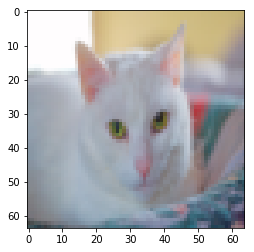

In [32]:
plt.imshow(test_x_orig[demo_index])
print ("My Prediction = " + str(y_pred_demo) + ". It's a " + classes[y_pred_demo].decode("utf-8") +  " picture.")
print("Actual="+ str(test_y[demo_index,0]) + ". It's a " + classes[test_y[demo_index,0]].decode("utf-8") +  " picture.")

In [4]:
#Loading a saved model
import keras
saved_model=keras.models.load_model('cat_recognizer_v1.h5')

In [5]:
saved_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 20)                245780    
_________________________________________________________________
dense_17 (Dense)             (None, 7)                 147       
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 40        
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 6         
Total params: 245,973
Trainable params: 245,973
Non-trainable params: 0
_________________________________________________________________
